In [1]:
import numpy as np
import pandas as pd
from astropy import table
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scipy import interpolate
import treecorr as tc
from astropy.io.misc.hdf5 import read_table_hdf5
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord



In [2]:
input_name = 'mock_elg_cat' #using the small version of skysim5000
input_file_name = f'{input_name}.hdf5'
mock_elg_cat_path = str(Path(f'../data/mock_cats/{input_file_name}'))
key = 'df'
mock_elg_cat = pd.read_hdf(mock_elg_cat_path, key=key)



Text(0.5, 0, 'RA')

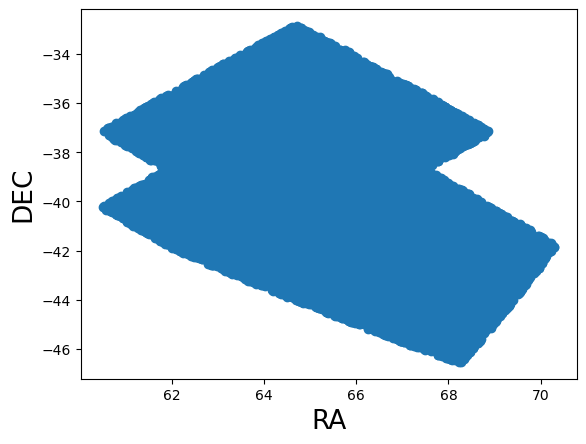

In [4]:
plt.scatter(mock_elg_cat['ra'], mock_elg_cat['dec'])
plt.ylabel('DEC', fontsize=19 )
plt.xlabel('RA', fontsize=19)

In [5]:
redshift = mock_elg_cat['redshift']
r = cosmo.comoving_distance(redshift).value # units of Mpc
ra = mock_elg_cat['ra']
dec = mock_elg_cat['dec']


In [21]:
NUM_POINTS = len(mock_elg_cat) * 10
DIST_WITHIN_SIM = 1/2 # arcmin
RA_MIN = np.min(ra)
RA_MAX = np.max(ra)
DEC_MIN = np.min(dec)
DEC_MAX = np.max(dec)

rand_ra = np.min(mock_elg_cat['ra']) + (np.max(mock_elg_cat['ra']) - np.min(mock_elg_cat['ra']))*np.random.random(size=NUM_POINTS)
cth_min = np.min(np.sin(np.radians(mock_elg_cat['dec'])))
cth_max = np.max(np.sin(np.radians(mock_elg_cat['dec'])))
cth_rand = cth_min + (cth_max - cth_min)*np.random.random(size=NUM_POINTS)
rand_dec = np.degrees(np.arcsin(cth_rand))
rand_redshift = np.random.choice(redshift, size=NUM_POINTS)

rand_coord = SkyCoord(rand_ra, rand_dec, unit=u.degree)
sim_coord = SkyCoord(ra, dec, unit=u.degree)
idx, d2d, d3d = rand_coord.match_to_catalog_sky(sim_coord)
dmask = d2d.arcmin < DIST_WITHIN_SIM



In [29]:
len(mock_elg_cat)

26488

In [30]:
print(dmask.sum())

13923


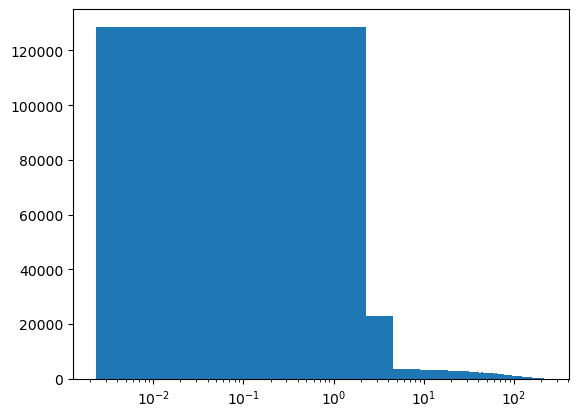

In [31]:
plt.hist(d2d.arcmin, bins=100)
plt.xscale('log')

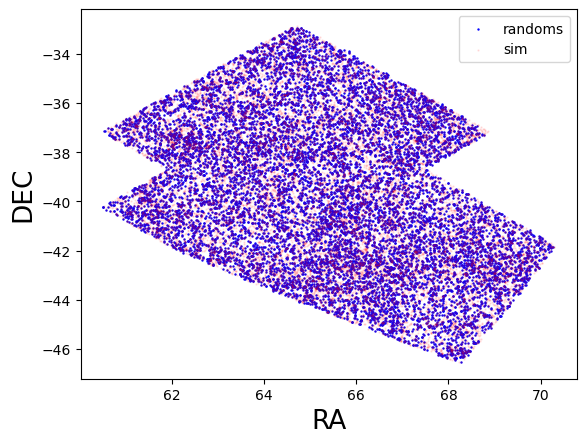

In [28]:
plt.scatter(rand_ra[dmask], rand_dec[dmask], color='blue', label='randoms', s=0.5)
plt.scatter(ra, dec, label='sim', color='red', alpha=0.1, s=0.5)
plt.ylabel('DEC', fontsize=19)
plt.xlabel('RA', fontsize=19)
plt.legend()

[]

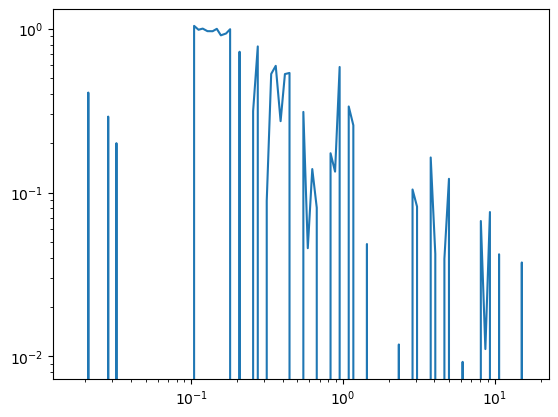

In [22]:
MIN_SEP = 1/60.
MAX_SEP = 1000/60.
NBINS = 100

tc_cat = tc.Catalog(ra=ra, dec=dec, ra_units='degrees', dec_units='degrees')
tc_rnd = tc.Catalog(ra=rand_ra[dmask], dec=rand_dec[dmask], ra_units='degrees', dec_units='degrees')


dd = tc.NNCorrelation(min_sep=MIN_SEP, max_sep=MAX_SEP, nbins=NBINS, sep_units='arcmin')
dr = tc.NNCorrelation(min_sep=MIN_SEP, max_sep=MAX_SEP, nbins=NBINS, sep_units='arcmin')
rr = tc.NNCorrelation(min_sep=MIN_SEP, max_sep=MAX_SEP, nbins=NBINS, sep_units='arcmin')

dd.process(tc_cat)
dr.process(tc_cat, tc_rnd)
rr.process(tc_rnd)

xi, _ = dd.calculateXi(rr=rr, dr=dr)
plt.plot(dd.meanr, xi)
plt.loglog()

In [ ]:
# compare ra vs dec for both the data and randoms

plt.scatter(mock_elg_cat['ra'][mask_data], mock_elg_cat['dec'][mask_data], color= 'red', label='Data')
#plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], color='blue', alpha= 0.5, label='Randoms')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()

In [ ]:
xi, _ = dd.calculateXi(rr=rr, dr=dr)
plt.plot(dd.meanr, xi)
plt.xlabel('Separation')
plt.ylabel('Correlation function')
plt.xscale('log')